In [1]:
# EXECUTING THE FOLLOWING WILL INSTALL GLOBAL DEPENDENCIES ON YOUR SYSTEM.
# ONLY RUN FOR GOOGLE COLAB INSTANCES, ETC.
# Installs Pyomo (modeling language) and IPOPT (solver). See http://www.pyomo.org/ and https://coin-or.github.io/Ipopt/.

# !pip install pyomo
# !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
# !unzip -o -q ipopt-linux64

from pyomo.environ import (
    SolverFactory,
    AbstractModel,
    Param,
    RangeSet,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeIntegers, PositiveReals, NonNegativeReals, Reals  # type: ignore

import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots as _

plt.style.use("ieee")  # Comment out if not supported

solver = SolverFactory("ipopt")
solver.options["max_iter"] = 10000

## Reservoir Stats

- Name: Curve Reservoir
- Coordinates: $36.33385606273248, -111.6578894846542$

### Old Stats (from Quinn's initial findings)

- Perimeter: $699.69$ m
- Maximum area: $19,991.22$ m^2
- Catchment area: m^2
- Elevation: $1,815$ m
- $c_1$: $30.684$
- $c_2$: $0.978$

### Updated Stats (from paper)

- Maximum area: $21,085$ m
- Catchment area: $1.6 \cdot 10^7$ m^2
- $c_1$: $1.4534$
- $c_2$: $1.1919$

## Workaround for bounding overflow

Original formulation is $w(t) = \text{max}\{v(k+1) - S, 0\}$, but Pyomo (and other solvers in general?) do not support decision variables/computations. Here's the workaround, by introducing an unbounded $w_u$ that can be negative (when $v(t + 1) < S$).

$$
\begin{align*}
    w_u(t)
    &= v(t + 1) - S \in \R \\
    w(t)
    &= \text{max}(0, w_u(t)) \in \R_{\geq 0}\\
    &= \frac12 (w_u + |w_u|)
\end{align*}
$$


In [2]:
# TODO: Change t to k, fix mutability warnings
mu = 1e-6

model = AbstractModel()

# Set `K` of period indices
model.num_periods = Param(within=NonNegativeIntegers)
model.T_periods = RangeSet(0, model.num_periods - 1)
model.T_points = RangeSet(0, model.num_periods)

# Constant parameters
model.c1 = Param(within=PositiveReals)  # Scalar constant c1 for volume
model.c2 = Param(within=PositiveReals)  # Scalar constant c2 for volume
model.A_c = Param(within=PositiveReals)  # Catchment area
model.A_max = Param(within=PositiveReals)  # Maximum surface area
model.Q_max = Param(within=NonNegativeReals)  # Maximum pumping rate
model.E_coeff = Param(within=PositiveReals)  # Evaporation coefficient

# Time-varying parameters
model.P = Param(model.T_periods, within=NonNegativeReals)  # Precipitation rate
model.E_pan = Param(model.T_periods, within=NonNegativeReals)  # Pan evaporation rate

# Time-invariant parameters
model.S_max = Param(
    initialize=model.c1 * (mu + model.A_max) ** model.c2
)  # Maximum storage capacity
model.R = Param(
    model.T_periods,
    default=lambda model, t: model.A_c * model.P[t],
    within=NonNegativeReals,
)  # Calculate rainfall [6]

# Optimizable variables
model.V = Var(model.T_points, domain=NonNegativeReals)  # Volume
model.S = Var(model.T_points, domain=NonNegativeReals)  # Storage
model.A = Var(model.T_points, domain=NonNegativeReals)  # Surface area
model.E = Var(model.T_periods, domain=NonNegativeReals)  # Evaporation
model.Q = Var(model.T_periods, domain=NonNegativeReals)  # Pumping
model.W = Var(model.T_periods, domain=NonNegativeReals)  # Overflow

model.unbounded_W = Var(model.T_periods, domain=Reals)  # Possibly negative overflow

# Objective
model.min_overflow = Objective(
    expr=lambda model: sum(model.W[t] for t in model.T_periods)
)  # Minimize overflow
# model.trivial = Objective(expr=lambda _: 0)  # TEMPORARY: To verify model feasibility

# Constraints
model.volume = Constraint(
    model.T_periods,
    rule=lambda model, t: model.V[t + 1]
    == model.S[t] + model.R[t] - model.E[t] - model.Q[t],
)  # Volumetric balance equation [1]

model.unbounded_overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.unbounded_W[t] == model.V[t + 1] - model.S_max,
)  # Calculate unbounded overflow (possibly negative)

model.overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.W[t]
    == (model.unbounded_W[t] + abs(model.unbounded_W[t]))
    / 2,  # Equivalent to max(0, model.unbounded_W[t]) [2]
)  # Calculate (bounded) overflow [2]

model.evaporation = Constraint(
    model.T_periods,
    rule=lambda model, t: model.E[t]
    == (model.A[t] + model.A[t + 1]) / 2 * model.E_coeff * model.E_pan[t],
)  # Calculate evaporation [7]

model.storage = Constraint(
    model.T_periods,
    rule=lambda model, t: model.S[t + 1] == model.V[t + 1] - model.W[t],
)  # Bound storage [3]

model.storage_to_area = Constraint(
    model.T_points,
    rule=lambda model, t: model.S[t] == model.S_max / model.A_max * model.A[t],
)  # Relate storage to area [4]

# model.upper_A = Constraint(
#     model.T_points, rule=lambda model, t: model.A[t] <= model.A_max
# )  # Bound surface area [5] (Redundant?)

model.upper_Q = Constraint(
    model.T_periods, rule=lambda model, t: model.Q[t] <= model.Q_max
)  # Bound pumping [8]

# model.initial_S = Constraint(rule=lambda model: model.S[0] == mu)
# model.initial_V = Constraint(rule=lambda model: model.S[6] == mu)

In [3]:
N_BARS = 4
WIDTH = 1.0 / N_BARS


def plot_model(instance: AbstractModel, debug=False) -> None:
    volume = np.array([instance.V[i].value for i in instance.T_points])
    storage = np.array([instance.S[i].value for i in instance.T_points])
    rainfall = np.array([instance.R[i] for i in instance.T_periods])
    evaporation = np.array([instance.E[i].value for i in instance.T_periods])
    pumping = np.array([instance.Q[i].value for i in instance.T_periods])
    overflow = np.array([instance.W[i].value for i in instance.T_periods])

    assert (
        np.equal(volume.shape, storage.shape)
        and np.unique(
            [rainfall.shape, evaporation.shape, pumping.shape, overflow.shape]
        ).size
        == 1
    )

    x_periods = np.arange(rainfall.size)

    if debug:
        print("Volume:", volume)
        print("Storage:", storage)
        print("Rainfall:", rainfall)
        print("Evaporation:", evaporation)
        print("Pumping:", pumping)
        print("Overflow:", overflow)

    plt.rcParams["figure.figsize"] = [8, 5]
    plt.title("Hydraulic Storage Model")
    plt.plot(
        volume, "-bo", alpha=0.5, label="Volume", markersize=2
    )  # Could omit last/12-th point (volume[:-1])
    plt.plot(storage, "-ro", alpha=0.5, label="Storage", markersize=2)  # sim.
    plt.bar(
        x_periods,
        rainfall,
        width=WIDTH,
        color="y",
        alpha=0.5,
        label="Rainfall",
    )
    plt.bar(
        x_periods + WIDTH,
        evaporation,
        width=WIDTH,
        color="g",
        alpha=0.5,
        label="Evaporation",
    )
    plt.bar(
        x_periods + 2 * WIDTH,
        pumping,
        color="c",
        width=WIDTH,
        alpha=0.5,
        label="Pumping",
    )
    plt.bar(
        x_periods + 3 * WIDTH,
        overflow,
        width=WIDTH,
        color="m",
        alpha=0.5,
        label="Overflow",
    )
    plt.hlines(
        y=instance.S_max.value,
        xmin=0,
        xmax=instance.num_periods,
        alpha=0.5,
        linestyles="dashed",
        label="Max Storage",
    )

    plt.xlabel("Time (months 0-11)")
    plt.ylabel("Volume (m$^3$)")
    plt.legend(prop={"size": 8}, ncol=3)
    plt.show()

In [4]:
N_PERIODS = 12

PRECIP_RATE = 0.0254 * np.array(
    [0.55, 0.51, 0.59, 0.28, 0.31, 0.16, 0.67, 0.71, 0.98, 0.87, 0.43, 0.31]
)  # in/month -> m/month (m)

# Pan evporation rate (in/month)}
PAN_COEFF = 0.8
PAN_EVAP_RATE = 0.0254 * np.array(
    [
        2.45,
        2.60,
        5.84,
        8.27,
        10.72,
        12.86,
        13.06,
        11.38,
        8.42,
        5.13,
        2.29,
        2.45,
    ]
)  # in/month -> m/month (m)

C1, C2 = 1.4534, 1.1919
CATCHMENT_AREA = 0.2 * 1.6 * 1e7  # (m^2)
MAX_SURFACE_AREA = 21085  # (m^2)

In [5]:
# Hourly weather data
pga_df = utils.load_mesonet(
    "/Users/quinnouyang/Desktop/Work-ish/CERG/Bodaway Gap/Water Optimization/dynamics_model/PGA_2005_2020.csv"
)
# Hourly solar data
irr_df = utils.load_pvgis(
    "Water Optimization/dynamics_model/curve_radiation_2005_2020.csv"
)

# Averaged monthly pan evaporation rate (https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg)
pan_m_df = pd.DataFrame(
    {
        "month": list(range(1, 13)),
        "evap": [
            2.45,  # Interpolated (originally 0.00)
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            2.45,  # Interpolated (originally 0.00)
        ],
    }
)

# Pan rate (in/month) -> Reservoir rate (mm/day) (assuming 30 days/month)
pan_m_df["est"] = 0.8 * pan_m_df["evap"] * 25.4 / 30

In [6]:
# Monthly weather and solar data
pga_m_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "M")
irr_m_df = utils.get_mean(irr_df, "time", ["G(i)"], "M")

# Monthly reservoir data: weather and solar
res_m_df = pd.merge(
    pga_m_df,
    irr_m_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

# Estimate monthly evaporation using
res_m_df["est"] = res_m_df.apply(
    lambda row: utils.get_evaporation_rate(
        row["tmpc"], row["dwpc"], 1815, row["G(i)"], row["smps"]
    ),
    axis=1,
)

# Averaged monthly evaporation
res_m_mean_df = res_m_df["est"].groupby(res_m_df["month"]).mean()

Fitted Parameters:  [ 1.00388135e-02 -4.91198991e-03  1.54811020e-05  5.15930692e-01
  8.33595076e+01 -4.05928847e+03  9.66204905e+02 -7.92952919e-02]


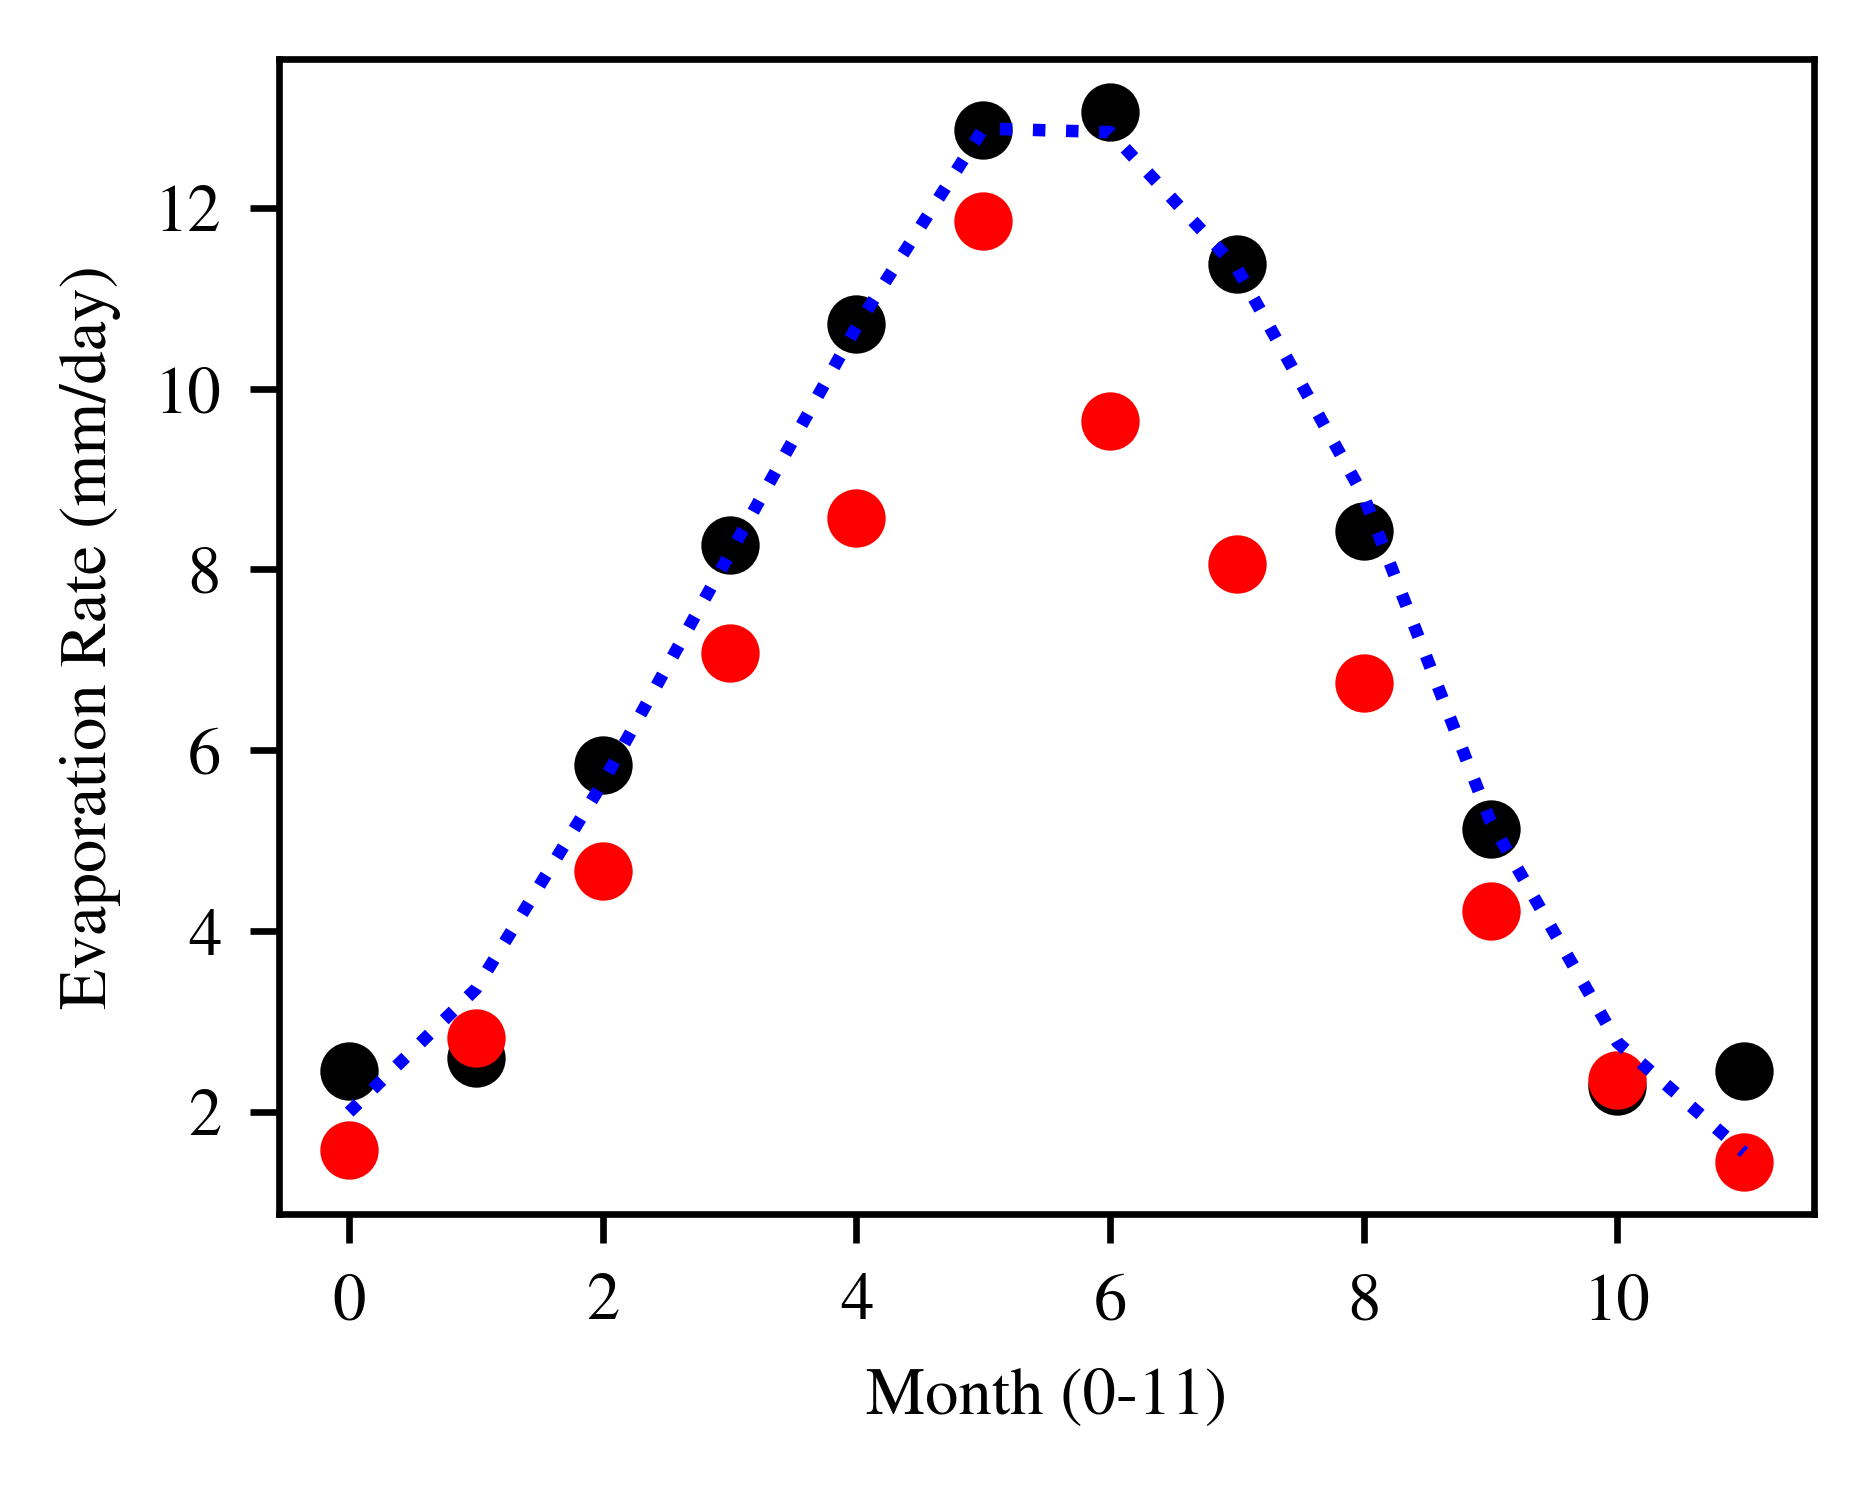

In [7]:
# Averaged monthly reservoir data
res_m_data = (
    res_m_df.groupby("month").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
)

pan_m_evap = pan_m_df.evap.to_numpy()
popt = utils.get_fit_parameters(res_m_data, pan_m_evap)

print("Fitted Parameters: ", popt)
plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["evap"].to_numpy(), "o")  # Pan estimations
plt.plot(res_m_mean_df.to_numpy(), "o")  # Model predictions
plt.plot(
    pan_m_df["month"].to_numpy() - 1,
    utils.evaporation_rate_curve(res_m_data, *popt),
    "b",
)

### Daily Interpolation


In [8]:
# Daily weather and solar data
pga_d_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps", "p01i"], "D")
irr_d_df = utils.get_mean(irr_df, "time", ["G(i)"], "D")

# Monthly reservoir data: weather and solar
res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

print(res_d_df.describe())

# Estimate average daily evaporation
d_evap = utils.evaporation_rate_curve(
    res_d_df.groupby(["month", "day"])
    .mean()[["tmpc", "dwpc", "G(i)", "smps"]]
    .to_numpy(),
    *popt
)
# Average daily precipitation
d_precip = (
    utils.get_sum(pga_df, "valid", ["p01i"], "D")
    .groupby(["month", "day"])
    .mean()["p01i"]
    .to_numpy()
)

print(d_evap.shape, d_precip.shape)

              tmpc         dwpc         smps      p01i         year  \
count  4571.000000  4571.000000  4571.000000    4571.0  4571.000000   
mean     15.939003    -1.689630     2.207147  0.002331  2013.792387   
std      10.276620     7.383473     1.356138    0.0132     4.200760   
min     -10.000000   -20.116667     0.000000       0.0  2005.000000   
25%       6.877083    -7.000000     1.328980       0.0  2010.000000   
50%      15.611110    -2.731481     2.014906       0.0  2014.000000   
75%      25.136210     2.841071     2.829442  0.000008  2017.000000   
max      40.611110    18.016667    12.861100  0.465025  2020.000000   

             month          day        G(i)  
count  4571.000000  4571.000000      4571.0  
mean      6.538175    15.635310  239.549118  
std       3.438745     8.792764    84.64286  
min       1.000000     1.000000   19.897917  
25%       4.000000     8.000000  161.856873  
50%       7.000000    16.000000  248.391251  
75%      10.000000    23.000000  310.9

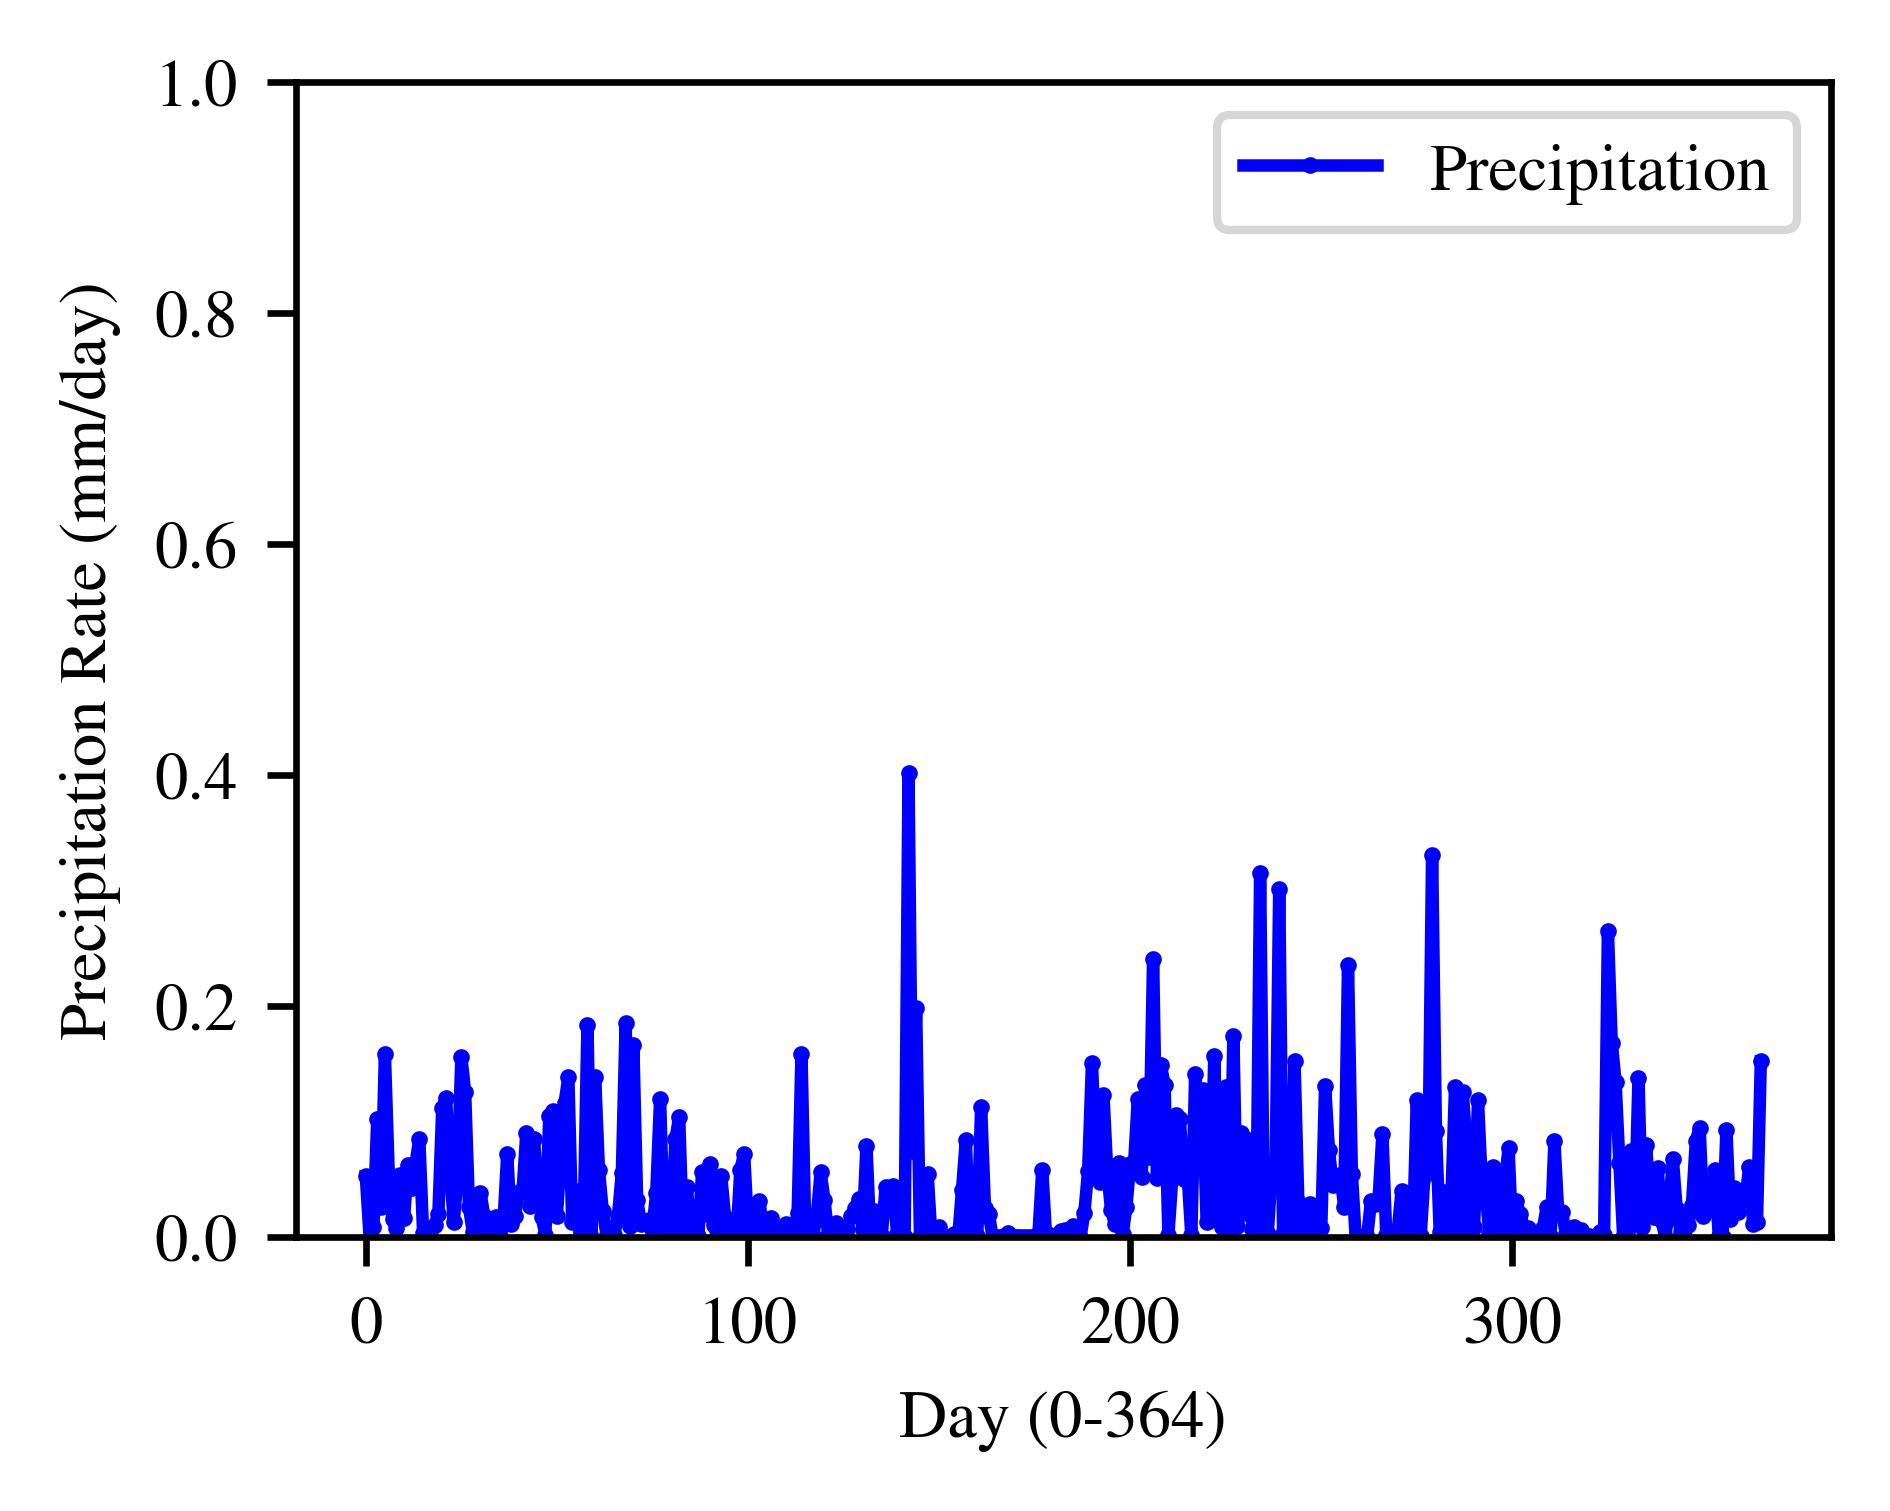

In [9]:
# d_evap[d_evap < 0] = 0
# d_precip[d_precip < 0] = 0

plt.figure()
plt.xlabel("Day (0-364)")
plt.ylabel("Precipitation Rate (mm/day)")
# plt.plot(d_evap, "-ro", label="Evaporation", markersize=1)  # Model predictions
plt.plot(d_precip, "-bo", label="Precipitation", markersize=1)  # Precipitation
plt.ylim(0, 1)
plt.legend()

or mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)


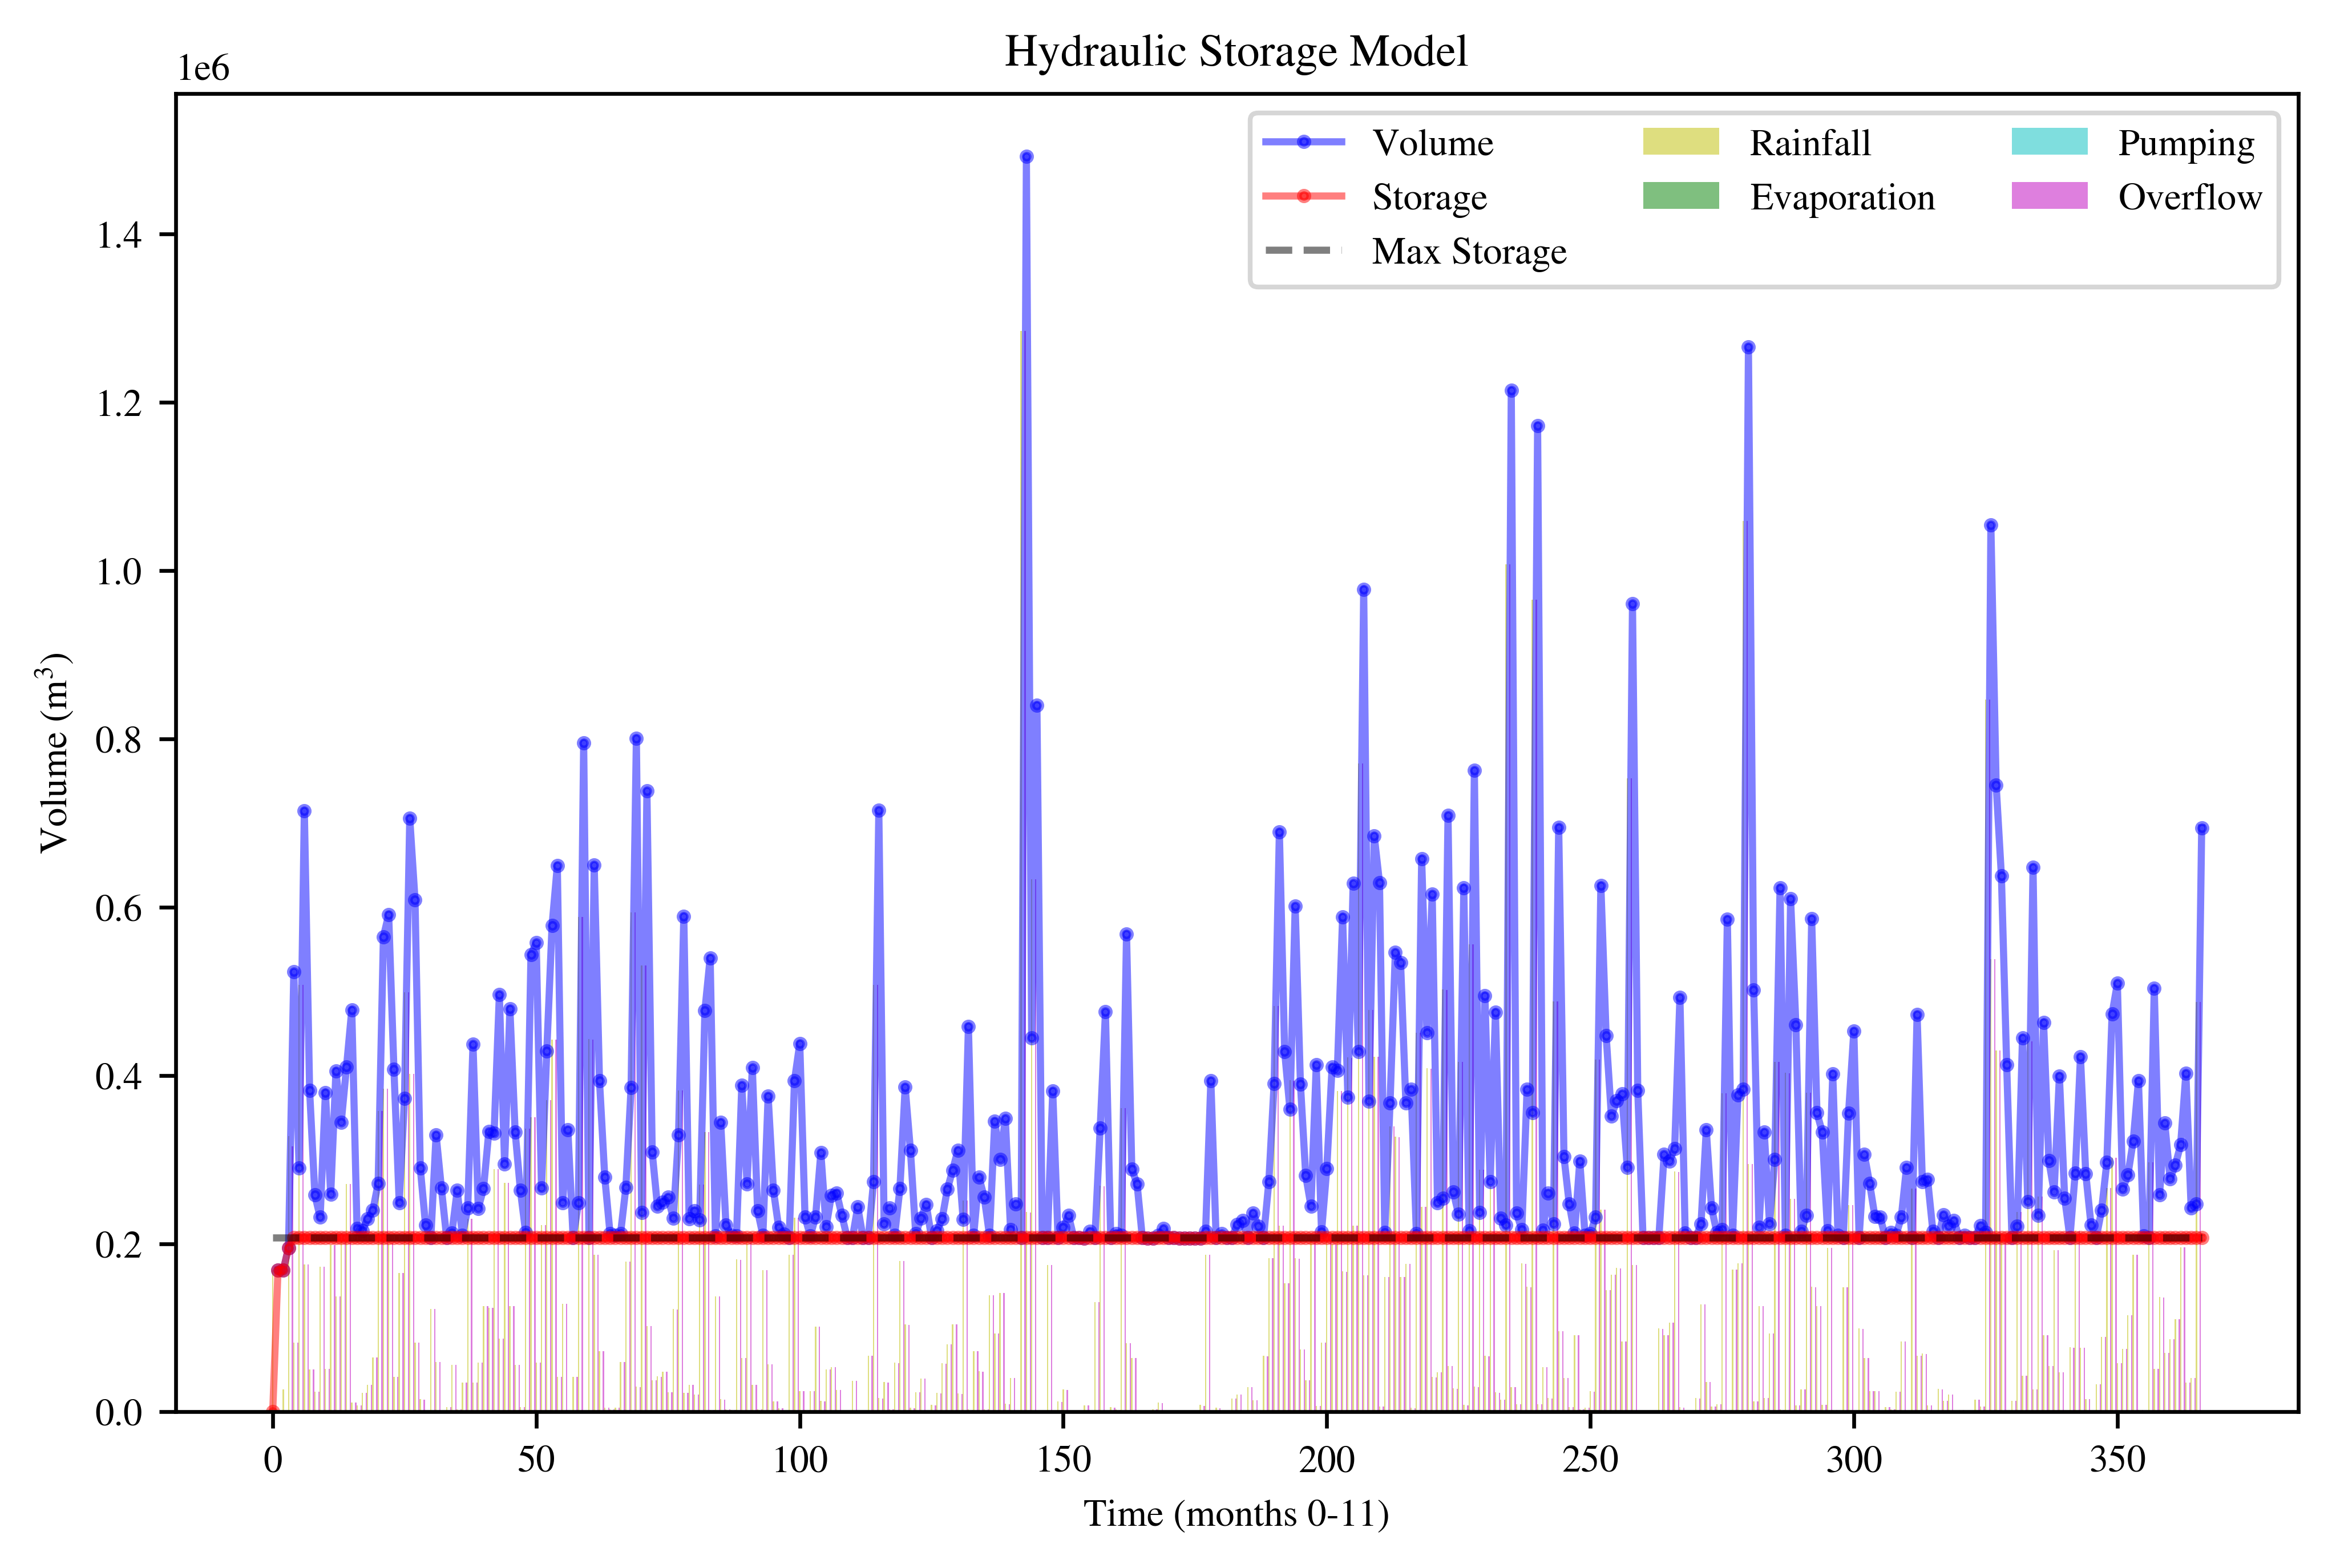

In [10]:
data = {
    None: {
        "num_periods": {None: d_evap.size},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": dict(enumerate(d_precip)),
        "E_pan": dict(
            enumerate(np.concatenate((np.repeat(PAN_EVAP_RATE / 30, 30), np.zeros(6))))
        ),
        # "E_pan": dict(enumerate(d_evap)),
        "E_coeff": {None: 0.8},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)

plot_model(instance)

In [11]:
instance.pprint()

2 RangeSet Declarations
    T_periods : Dimen=1, Size=366, Bounds=(0, 365)
        Key  : Finite : Members
        None :   True : [0:365]
    T_points : Dimen=1, Size=367, Bounds=(0, 366)
        Key  : Finite : Members
        None :   True : [0:366]

11 Param Declarations
    A_c : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None : 3200000.0000000005
    A_max : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None : 21085
    E_coeff : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :   0.8
    E_pan : Size=366, Index=T_periods, Domain=NonNegativeReals, Default=None, Mutable=False
        Key : Value
          0 : 0.0020743333333333334
          1 : 0.0020743333333333334
          2 : 0.0020743333333333334
          3 : 0.0020743333333333334
          4 : 0.0020743333333333334
          5 : 0.0020743333333333334
          6